In [21]:
import itertools
import numpy as np
import pandas as pd
import glob
import json
import matplotlib.pyplot as plt
import numpy as np

In [26]:
search_root = "/checkpoint/jth/job_staging/neuraldb/"
files = glob.glob("{}*/*ndb*t5-base*mips_embs2*/*/metrics.json".format(search_root))
print(files)
print(len(files))

[]
0


In [23]:
def expand(idx,chunk):
  if idx == 0:
    return ["job_id={}".format(chunk)]
  #elif idx == 1:
  #  return ["experiment={}".format(chunk)]
  elif chunk.startswith("seed-"):
    return ["seed={}".format(chunk.replace("seed-",""))]
  elif "," in chunk:
    return chunk.split(",")
  return []

all_results = []
for file in files:
    chunks = file.replace(search_root,"").split("/")
    chunks = itertools.chain(*[expand(idx, chunk) for idx, chunk in enumerate(chunks)])

    data = {k:v for k,v in (chunk.split("=") for chunk in chunks)}

    with open(file) as f:
        try:
          metrics = json.load(f)
        except:
          print(f.readlines())
        if "validation" not in metrics or len(metrics["validation"])<2:
          continue

        epoch_em = [epoch["EM"] for epoch in metrics["validation"]]

        best_epoch_num = np.argmax(epoch_em)
        metrics = {"best_validation_epoch": metrics["validation"][best_epoch_num]["epoch"],
                   "best_validation_em": metrics["validation"][best_epoch_num]["EM"],
                   "best_validation_loss": metrics["validation"][best_epoch_num]["avg_val_loss"]
                  }

    data["context"] = int(data["context"])
    data["max_queries"] = int(data["max_queries"]) if data['max_queries'] != "null" else -1
    data.update(metrics)

    all_results.append(data)

results = pd.DataFrame(all_results)


In [24]:
pd.set_option("display.max_rows", 500)
pt = pd.pivot_table(results, index=["model","context","lr"],columns=["version"],aggfunc={"best_validation_em":[np.mean,np.std]})
pt

best_validation_em                              
                                   mean                 std          
version                            v0.2      v0.4      v0.2      v0.4
model   context lr                                                   
t5-base 50      1e-3           0.646071  0.669590  0.030619  0.089212
                1e-4           0.495380       NaN  0.004217       NaN
                2e-3           0.460289  0.466252  0.034806  0.003749
                3e-4           0.648440       NaN  0.077028       NaN
                5e-3           0.437735  0.382973  0.005881  0.007213
                5e-4           0.653896       NaN  0.007856       NaN
                8e-4           0.685054       NaN  0.021597       NaN
        100     1e-3           0.490948       NaN  0.037558       NaN
                1e-4           0.437670       NaN  0.002665       NaN
                2e-3           0.444849       NaN  0.008823       NaN
                3e-4           0.458377       NaN  0.008535       NaN
                5e-3           0.434747       NaN  0.005331       NaN
                5e-4           0.457181       NaN  0.010906       NaN
                8e-4           0.512398       NaN  0.039490       NaN

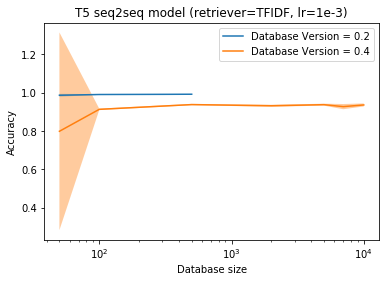

In [5]:
all_v2 = pt["best_validation_em"]["mean"]["v0.2"]["t5-base"]
all_v4 = pt["best_validation_em"]["mean"]["v0.4"]["t5-base"]

all_v2_std = pt["best_validation_em"]["std"]["v0.2"]["t5-base"]
all_v4_std = pt["best_validation_em"]["std"]["v0.4"]["t5-base"]

v2_datasets = [50,100,300,500]
v4_datasets = [50,100,500,2000,5000,7000,10000]

plt.title("T5 seq2seq model (retriever=TFIDF, lr=1e-3)")
plt.ylabel("Accuracy")
plt.xlabel("Database size")

v2_series = [all_v2[data_size]["1e-3"] for data_size in v2_datasets]
v4_series = [all_v4[data_size]["1e-3"] for data_size in v4_datasets]

v2_l_series = [all_v2[data_size]["1e-3"]-2*all_v2_std[data_size]["1e-3"] for data_size in v2_datasets]
v4_l_series = [all_v4[data_size]["1e-3"]-2*all_v4_std[data_size]["1e-3"] for data_size in v4_datasets]

v2_h_series = [all_v2[data_size]["1e-3"]+2*all_v2_std[data_size]["1e-3"] for data_size in v2_datasets]
v4_h_series = [all_v4[data_size]["1e-3"]+2*all_v4_std[data_size]["1e-3"] for data_size in v4_datasets]

plt.plot(v2_datasets,v2_series)
plt.fill_between(v2_datasets, v2_l_series,v2_h_series, alpha=0.4)
plt.plot(v4_datasets,v4_series)
plt.fill_between(v4_datasets, v4_l_series,v4_h_series, alpha=0.4)

plt.xscale("log")

plt.legend(["Database Version = 0.2", "Database Version = 0.4"])
plt.show()

In [6]:
all_tfidf = pt["best_validation_accuracy"]["mean"]["tfidf"]["bert_cls"]

datasets = [50,100,300,500]

plt.title("TFIDF Retrieval")
plt.ylabel("Accuracy")
plt.xlabel("Number of training queries")

for data_size in datasets:
  plt.plot(all_tfidf[data_size][1:])

plt.legend(["Context size = {}" .format(data) for data in datasets])
plt.show()


KeyError: 'best_validation_accuracy'

In [ ]:
all_bm25 = pt["best_validation_accuracy"]["mean"]["bm25"]["bert_cls"]
all_tfidf = pt["best_validation_accuracy"]["mean"]["tfidf"]["bert_cls"]


plt.title("BERT Discriminative Model (v0.2) + Information Retrieval Baselines")
plt.ylabel("Accuracy")
plt.xlabel("Context Size")

datasets = [50,100,300,500]
plt.plot(datasets, [all_tfidf[ds][-1] for ds in datasets])
plt.plot(datasets, [all_bm25[ds][-1] for ds in datasets])

plt.legend(["TFIDF","BM25"])
plt.show()